In [1]:
import glob
import os
import random
import shutil
import sys
from pathlib import Path

import numpy as np
import scipy.io
import torch

current_dir = os.path.dirname(os.path.abspath("__file__"))  # 当前目录
parent_dir = os.path.abspath(os.path.join(current_dir, ".."))  # 上一级目录
sys.path.append(parent_dir)
grandparent_dir = os.path.abspath(os.path.join(parent_dir, ".."))  # 上两级目录
sys.path.append(grandparent_dir)

import data_function
import metrics
import tools
import utils
from utils.config_plot import *
from ex_main.model import *
from ex_main.train_dataloader import getData

In [2]:
# Config
config_file_path = "/home/hy/project/reid/ex_main/config.py"
config = utils.common.read_config_file(config_file_path)

# Initialize a logger tool
logger = utils.logger.Logger(config.outputs_path)
logger.info("#" * 50)
logger.info(f"Task: {config.taskname}")
logger.info(f"Using device: {config.device}")
logger.info(f"Using data type: {config.dtype}")

# Set environment
random.seed(config.seed)
np.random.seed(config.seed)
torch.manual_seed(config.seed)
torch.cuda.manual_seed(config.seed)
torch.cuda.manual_seed_all(config.seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False  # The result cannot be reproduced when True

2024-03-11 10:47:10 INFO ##################################################
2024-03-11 10:47:10 INFO Task: ReID_Task
2024-03-11 10:47:10 INFO Using device: cuda
2024-03-11 10:47:10 INFO Using data type: torch.float32


Best Rank1 in epoch: 100 is 94.626%
Best mAP in epoch: 90 is 87.136%


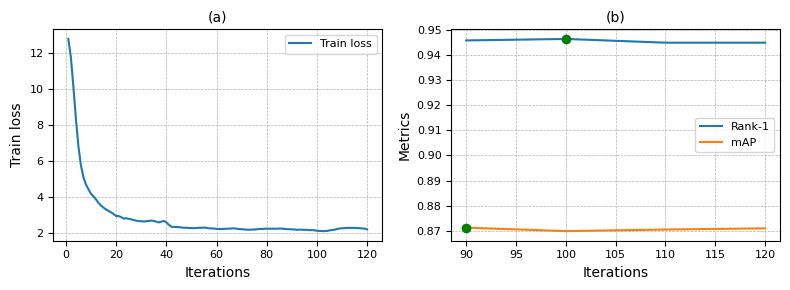

In [3]:
######################################################################
#
# Information
#
######################################################################
# Get recorder of model
path = os.path.join(config.outputs_path, "recorder.pkl")
recorder = utils.common.from_pickle(path)
train_epochs_list = recorder["train_epochs_list"]
train_loss_list = recorder["train_loss_list"]
val_epochs_list = recorder["val_epochs_list"]
val_CMC_list = np.array(recorder["val_CMC_list"])
val_mAP_list = np.array(recorder["val_mAP_list"])

# Print information of Rank and mAP
print(
    "Best Rank1 in epoch: {} is {:.3f}%".format(
        val_epochs_list[np.argmax(val_CMC_list[:, 0])], np.max(val_CMC_list[:, 0]) * 100
    )
)
print(
    "Best mAP in epoch: {} is {:.3f}%".format(
        val_epochs_list[np.argmax(val_mAP_list)],
        np.max(val_mAP_list) * 100,
    )
)

# Plot results
num_lines = 1
num_rows = 2
fig, axs = plt.subplots(
    num_lines, num_rows, figsize=(4 * num_rows, 3 * num_lines), dpi=Latex_DPI
)

subfig = axs[0]
subfig.set_title("(a)")
subfig.set_xlabel("Iterations")
subfig.set_ylabel("Train loss")
subfig.plot(train_epochs_list, train_loss_list, label="Train loss")
# subfig.set_yscale("log")
subfig.legend()

subfig = axs[1]
subfig.set_title("(b)")
subfig.set_xlabel("Iterations")
subfig.set_ylabel("Metrics")
subfig.plot(val_epochs_list, val_CMC_list[:, 0], label="Rank-1")
subfig.plot(val_epochs_list, val_mAP_list, label="mAP")
subfig.plot(
    val_epochs_list[np.argmax(val_CMC_list[:, 0])],
    np.max(val_CMC_list[:, 0]),
    marker="o",
    color="g",
)
subfig.plot(
    val_epochs_list[np.argmax(val_mAP_list)],
    np.max(val_mAP_list),
    marker="o",
    color="g",
)
# subfig.set_yscale("log")
subfig.legend()

plt.tight_layout()

# path = os.path.join(output_dir, "loss_curve.png")
# plt.savefig(path)